In [26]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [27]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [28]:
use_cuda

False

In [33]:
imsize = 200  # desired size of the output image

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style = image_loader("images/fire.jpg").type(dtype)
content = image_loader("images/mountain.jpg").type(dtype)

assert style.size() == content.size(
),"we need to import style and content images of the same size"

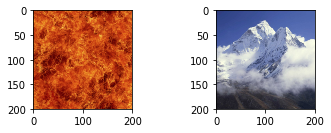

In [34]:
%matplotlib inline
unloader = transforms.ToPILImage()  # reconvert into PIL image


def imshow(tensor):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)


fig = plt.figure()

plt.subplot(221)
imshow(style.data)
plt.subplot(222)
imshow(content.data)

In [35]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [36]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [37]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [38]:
cnn = models.vgg19(True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [39]:
# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# just in order to have an iterable access to or list of content/syle losses
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = GramMatrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses
content_weight = 1
style_weight = 1000

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

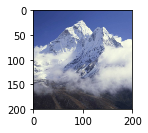

In [45]:
input = image_loader("images/mountain.jpg").type(dtype)
plt.subplot(223)
imshow(input.data)

In [46]:
# this line to show that input is a parameter that requires a gradient
input = nn.Parameter(input.data)
optimizer = optim.LBFGS([input])

run [10]:
80.72040557861328
1.8381139039993286
run [20]:
48.93763732910156
2.065469741821289
run [30]:
28.331357955932617
2.48520565032959
run [40]:
19.82223129272461
3.363027334213257
run [50]:
3.4202356338500977
2.997390031814575
run [60]:
1.8206764459609985
2.6912639141082764
run [70]:
1.2340083122253418
2.3196463584899902
run [80]:
0.9733005166053772
2.015462875366211
run [90]:
0.8773438334465027
1.8168771266937256
run [100]:
0.7618728876113892
1.6844978332519531
run [110]:
0.6851660013198853
1.5892287492752075
run [120]:
0.6935660243034363
1.483750581741333
run [130]:
0.5580223202705383
1.4406285285949707
run [140]:
0.4923127293586731
1.399902105331421
run [150]:
0.4364275336265564
1.361478567123413
run [160]:
0.3924720883369446
1.3379945755004883
run [170]:
0.3471809923648834
1.3046634197235107
run [180]:
0.3169214129447937
1.2877998352050781
run [190]:
0.33682510256767273
1.2634146213531494
run [200]:
0.25215405225753784
1.2476977109909058
run [210]:
0.2626504898071289
1.2387875

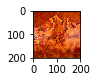

In [47]:
run = [0]
while run[0] <= 240:

    def closure():
        # correct the values of updated input image
        input.data.clamp_(0, 1)

        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 10 == 0:
            print("run " + str(run) + ":")
            print(style_score.data[0])
            print(content_score.data[0])

        return style_score+style_score

    optimizer.step(closure)

# a last correction...
input.data.clamp_(0, 1)
    
# finally enjoy the result:
plt.subplot(444)
imshow(input.data)
plt.show()

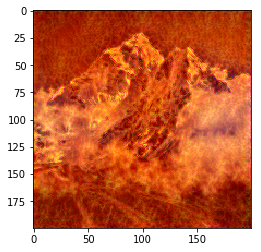

In [48]:
imshow(input.data)
plt.show()